### Task I.1

Collect the proof-of-concept above into a single function implementing the Jacobi iteration. This function should receive the r.h.s. matrix $A$, the l.h.s. vector `b`, and the number of iterations to perform.


The matrix $A$ in the illustration above is strongly diagonally dominant, by construction. 
What happens if the diagonal matrix elements of $A$ are made smaller? Check the convergence of the Jacobi iteration, and check the value of the norm of $B$.

(20% of the total grade)


 Для начала стоит скомпоновать приведенные выше условия в одну функцию 

In [174]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

rndm = np.random.RandomState(1234)
n, n_iter = 10, 50
A, b = rndm.uniform(size=(n, n)) + np.diagflat([15] * n), rndm.uniform(size = n)
A2 = rndm.uniform(size = (n, n)) - np.diagflat([0.5] * n)  # Заранее перейдем к изменению элементов матрицы                       
selec, esu = np.zeros(n), np.zeros(n)

def jax(A, b, N):                      
    n = np.shape(A)[0]
    x0 = np.ones(n)
    x = x0
    diag_1d = np.diag(A)
    B = -A.copy()
    np.fill_diagonal(B, 0)
    D = np.diag(diag_1d)
    invD = np.diag(1./diag_1d)
    BB = invD @ B 
    c = invD @ b 
    print(np.linalg.norm(BB)) # выводим норму
    for i in range(N):
        x = BB @ x + c
    return x, A @ x - b # выводим дополнительно погрешность

print(jax(A, b, n_iter)) # на этом шаге мы просто проверяем роботоспособность, до изменения А

for k in range(np.shape(A2)[0]):                      
    for m in range(np.shape(A2)[0]):
        if k != m:
            selec[k] += A2[k][m]

for k in range(np.shape(A2)[0]):
    if selec[k] <= A2[k][k]:
        esu[k] = 1
print(sum(esu)) # если выведет 0, то нет диагонального преобладания

jax(A2, b, 50)

0.36436161983015336
(array([ 0.03919429,  0.03780037,  0.04283232,  0.02365951,  0.05745031,
       -0.00030244, -0.00577279,  0.03177549, -0.00422849,  0.05284648]), array([ 1.11022302e-16,  1.11022302e-16, -1.11022302e-16,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.38777878e-17,  0.00000000e+00,
       -4.16333634e-17,  1.11022302e-16]))
0.0
39.45538993309787


(array([-1.39849628e+55,  3.86522283e+54,  4.48585488e+54,  2.33640562e+55,
         6.41192650e+54,  9.61215498e+54, -1.53137568e+55,  8.70442278e+54,
         6.61842336e+54, -1.13745251e+55]),
 array([ 2.90006306e+55,  1.26505131e+55, -9.57696351e+54,  3.44353088e+54,
        -3.88709615e+54,  2.47798939e+55,  2.96107545e+55,  1.24269700e+55,
        -3.22788176e+54,  3.27461538e+55]))

#### В итоге если нет диагонального преобладания, то норма B будет больше единицы и метод расходится


# II. Seidel's iteration.

##### Task II.1

Implement the Seidel's iteration. 

Test it on a random matrix. Study the convergence of iterations, relate to the norm of the iteration matrix.

(30% of the total grade)

In [125]:
L, G, vz, ld = 5, 25, np.zeros((L, G)), np.zeros((L, G)) # для будущих построений
lbst = []

def drax(A, b, N):
    n = np.shape(A)[0]
    x0 = np.ones(n)
    x = x0
    up, low, diag = np.tril(A, k=-1), np.triu(A, k=1), np.diag(np.diag(A)) # разбиение матриц
    invD = inv(D)
    BB = -invD @ (low + up)
    c = invD @ b 
    versa = inv(low + diag)
    for i in range(N):
        x = versa @ (b - up @ x)
    return x, A @ x - b, np.linalg.norm(BB, ord = np.inf) # дполнительно вывели норму матрицы итераций

drax(A, b, n_iter)

(array([ 0.06857064,  0.10595134,  0.05757072,  0.05733003,  0.05230108,
         0.0580254 ,  0.07214439, -0.02552008,  0.00676149,  0.00521096]),
 array([ 1.11022302e-16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.11022302e-16,  1.11022302e-16,  2.77555756e-17,
         0.00000000e+00,  0.00000000e+00]),
 0.3875786112313951)

Норма матрицы итерации =  0.3596898254311659


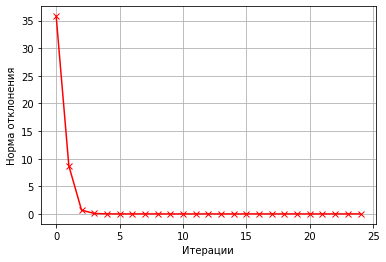

In [154]:
for k in range(L):
    A = rndm.uniform(size=(n, n)) + (k + 1) * 7 * np.eye(n)
    lbst.append(drax(A, b, 1)[2])
    for m in range(G):
        vz[k][m] = m
        ld[k][m] = np.linalg.norm(drax(A, b, m)[1])

print('Норма матрицы итерации = ', lbst[0])
plt.plot(vz[0], ld[0], 'x-', color='r')
plt.xlabel('Итерации')
plt.ylabel('Норма отклонения')
plt.grid()

Норма матрицы итерации =  0.38945406920990533


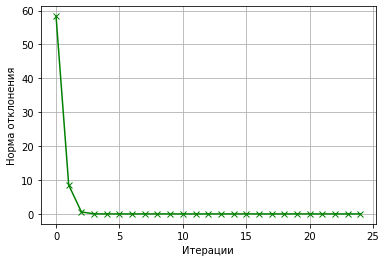

In [155]:
print('Норма матрицы итерации = ', lbst[1])
plt.figure()
plt.plot(vz[1], ld[1], 'x-', color='g')
plt.xlabel('Итерации')
plt.ylabel('Норма отклонения')
plt.grid()

Норма матрицы итерации =  0.4063153561594972


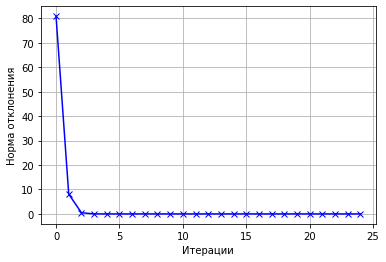

In [156]:
print('Норма матрицы итерации = ', lbst[2])
plt.figure()
plt.plot(vz[2], ld[2], 'x-', color='b')
plt.xlabel('Итерации')
plt.ylabel('Норма отклонения')
plt.grid()


#### => Наблюдается сходимость при норме меньше единицы

# III. Minimum residual scheme

### Task III.1

Implement the $\textit{minimum residual}$ scheme: an explicit non-stationary method, where at each step you select the iteration parameter $\tau_n$ to minimize the residual $\mathbf{r}_{n+1}$ given $\mathbf{r}_n$. Test it on a random matrix, study the convergence to the solution, in terms of the norm of the residual and the deviation from the ground truth solution (which you can obtain using a direct method). Study how the iteration parameter $\tau_n$ changes as iterations progress.

(50% of the grade)

In [221]:
def wax(A, b, N):
    n = np.shape(A)[0]
    x0 = np.ones(n)
    x = x0
    p = np.zeros(n)
    ti, it, nr, ot = [], [], [], []
    for k in range(N):
        p = A @ x - b
        c = A @ p
        t = (p @ c) / (np.linalg.norm(c)) ** 2
        x = x - t * p
        ti.append(t)
        it.append(k)
        nr.append(np.linalg.norm(p))
        ot.append(np.linalg.norm(A @ x - b))
    return x, A @ x - b, np.array(it), np.array(ti), np.array(nr), np.array(ot)

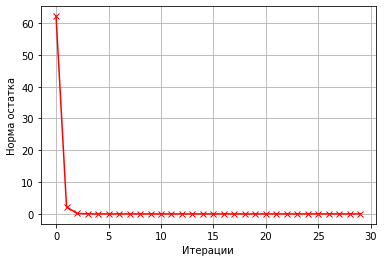

In [222]:
plt.plot(wax(A, b, 30)[2], wax(A, b, 30)[4], 'x-', color='r')
plt.xlabel('Итерации')
plt.ylabel('Норма остатка')
plt.grid()

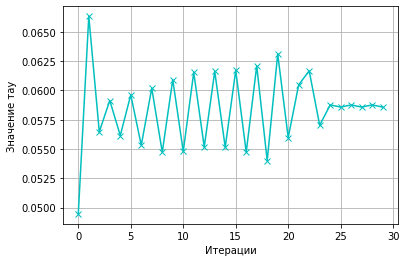

In [225]:
plt.figure()
plt.plot((wax(A, b, 30))[2], wax(A, b, 30)[3], 'x-', color='c')
plt.xlabel('Итерации')
plt.ylabel('Значение тау')
plt.grid()

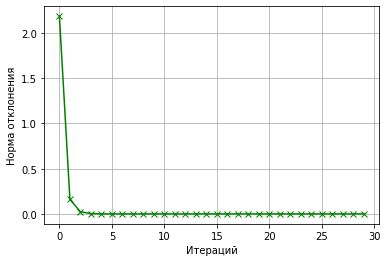

In [226]:
plt.figure()
plt.plot(wax(A, b, 30)[2], wax(A, b, 30)[5], 'x-', color='g')
plt.xlabel('Итераций')
plt.ylabel('Норма отклонения')
plt.grid()